# <center>Project: Wrangling and Analyze Data</center>

## Data Gathering

In [1]:
import numpy as np
import pandas as pd

In [2]:
twitter_archives = pd.read_csv('twitter_archive_enhanced.csv')

In [3]:
twitter_archives.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


**2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)**

In [4]:
import requests
from io import BytesIO

**_Load the mage_predictions.tsv file_**

In [5]:
data = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')


In [6]:
image_predictions = pd.read_csv(BytesIO(data.content), sep = '\t')

In [7]:
image_predictions.to_csv('image-predictions.tsv', sep='\t', )

**3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)**

In [8]:
import json
import tweepy

In [9]:
data = []
with open('tweet_json.txt', 'r') as readfile: 
    tweet_json = readfile.readline()
    while tweet_json:
        tweet_dict = json.loads(tweet_json)
        data.append(tweet_dict)
        tweet_json = readfile.readline()
        
tweet_api_data = pd.DataFrame.from_dict(data)

## Assessing Data

**Visualize tweet data**

In [10]:
tweet_api_data

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,Mon Nov 16 00:24:50 +0000 2015,666049248165822465,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
2336,Mon Nov 16 00:04:52 +0000 2015,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
2337,Sun Nov 15 23:21:54 +0000 2015,666033412701032449,666033412701032449,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
2338,Sun Nov 15 23:05:30 +0000 2015,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN


**Describe Tweet Data**

In [11]:
tweet_api_data.describe()

,id,in_reply_to_status_id,in_reply_to_user_id,retweet_count,favorite_count,quoted_status_id
count,2.340000e+03,7.700000e+01,7.700000e+01,2340.000000,2340.000000,2.600000e+01
mean,7.422176e+17,7.440692e+17,2.040329e+16,2922.045299,7948.772650,8.113972e+17
std,6.832564e+16,7.524295e+16,1.260797e+17,4922.595228,12311.859238,6.295843e+16
min,6.660209e+17,6.658147e+17,1.185634e+07,0.000000,0.000000,6.721083e+17
25%,6.783394e+17,6.757073e+17,3.589728e+08,586.500000,1372.250000,7.761338e+17
50%,7.186224e+17,7.032559e+17,4.196984e+09,1364.000000,3455.000000,8.281173e+17
75%,7.986954e+17,8.233264e+17,4.196984e+09,3403.250000,9726.250000,8.637581e+17
max,8.924206e+17,8.862664e+17,8.405479e+17,83427.000000,163981.000000,8.860534e+17


**Display Tweet Information**

In [12]:
tweet_api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2340 non-null   object 
 1   id                             2340 non-null   int64  
 2   id_str                         2340 non-null   object 
 3   full_text                      2340 non-null   object 
 4   truncated                      2340 non-null   bool   
 5   display_text_range             2340 non-null   object 
 6   entities                       2340 non-null   object 
 7   extended_entities              2067 non-null   object 
 8   source                         2340 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

**Check for Duplicates**

In [13]:
tweet_api_data.duplicated(subset=['id']).any()

False

**Check if the tweet may contain content identified as sensitive content**

In [14]:
tweet_api_data.possibly_sensitive_appealable.value_counts()

False    2205
Name: possibly_sensitive_appealable, dtype: int64

**Check common things included in tweets**

In [15]:
tweet_api_data.entities[0]

{'hashtags': [],
 'symbols': [],
 'user_mentions': [],
 'urls': [],
 'media': [{'id': 892420639486877696,
   'id_str': '892420639486877696',
   'indices': [86, 109],
   'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'url': 'https://t.co/MgUWQ76dJU',
   'display_url': 'pic.twitter.com/MgUWQ76dJU',
   'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
   'type': 'photo',
   'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
    'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
    'small': {'w': 540, 'h': 528, 'resize': 'fit'},
    'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}

In [16]:
tweet_api_data.extended_entities[0]

{'media': [{'id': 892420639486877696,
   'id_str': '892420639486877696',
   'indices': [86, 109],
   'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'url': 'https://t.co/MgUWQ76dJU',
   'display_url': 'pic.twitter.com/MgUWQ76dJU',
   'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
   'type': 'photo',
   'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
    'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
    'small': {'w': 540, 'h': 528, 'resize': 'fit'},
    'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}

**Check retweeted status**

In [17]:
tweet_api_data[tweet_api_data.retweeted_status.notnull()].retweeted_status[31]

{'created_at': 'Sat Jul 15 02:44:07 +0000 2017',
 'id': 886053734421102592,
 'id_str': '886053734421102592',
 'full_text': '12/10 #BATP https://t.co/WxwJmvjfxo',
 'truncated': False,
 'display_text_range': [0, 11],
 'entities': {'hashtags': [{'text': 'BATP', 'indices': [6, 11]}],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/WxwJmvjfxo',
    'expanded_url': 'https://twitter.com/dog_rates/status/886053434075471873',
    'display_url': 'twitter.com/dog_rates/stat…',
    'indices': [12, 35]}]},
 'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 19607400,
  'id_str': '19607400',
  'name': 'Oakland Athletics 🌳🐘⚾️',
  'screen_name': 'Athletics',
  'location': 'Oakland, CA',
  'description': 'Official Twitter of the nine-time World Series champion Athletics 

**Image Predections**

In [18]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [19]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
image_predictions.duplicated(subset=['tweet_id']).any()

False

In [22]:
image_predictions.duplicated(subset=['jpg_url']).any()

True

In [23]:
image_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

**Twitter Archives**

In [24]:
twitter_archives

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [25]:
twitter_archives.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

**Count different Dog Name Appearances**

In [26]:
twitter_archives.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [27]:
twitter_archives.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [28]:
twitter_archives.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [29]:
twitter_archives.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [30]:
twitter_archives.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [31]:
twitter_archives[twitter_archives['rating_numerator'] < 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None
229,848212111729840128,NaN,NaN,2017-04-01 16:35:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jerry. He's doing a distinguished tong...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/848212111...,6,10,Jerry,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
387,826598799820865537,8.265984e+17,4.196984e+09,2017-02-01 01:11:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I was going to do 007/10, but the joke wasn't ...",NaN,NaN,NaN,NaN,7,10,None,None,None,None,None
462,817502432452313088,NaN,NaN,2017-01-06 22:45:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Herschel. He's slightly bi...,6.924173e+17,4.196984e+09,2016-01-27 18:42:06 +0000,https://twitter.com/dog_rates/status/692417313...,7,10,Herschel,None,None,pupper,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [32]:
twitter_archives[twitter_archives['rating_denominator'] != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


## Quality issues

Below are key quality issues picked on the data
- data consistency
- data validity
- data completeness 
- data accuracy
The above quality issues have been dealt with by:
- dropig columns that are not needed and re-organise columns order so it becomes easier to read
- converting tweet_id column from a number to a string value
- converting the date and time columns to datetime objects
- converting the rating columns to float values
- consolidating the tweet_api_data table into tweet_id and retweet count
- converting tweet_api_data _id_ column from a number to a string


**1. twitter_archives**
- removing data columns that will not be used for the analysis
- only store original ratings with have images and remove retweets
- removing erroneous datatypes like doggo, floofer, pupper and puppo
- correctong numerators with decimals


**2. tweet_api_data table**
- this has sone unrelated columns such as favorited, user, retweeted which is subjective to who obtained the data
- the source column contain the whole html tag (<a href=" ... ">)

**3. image_predictions**
- creating a column for image prediction
- removing data columns that will not be used for the analysis
    
**4. retweet_count**
- This looks as a tweet that has been retweeted before in the retweet_count field - which provides the number of times the tweet was retweeted. 
- This number may vary over time, as additional people retweet the tweet.

**5. tweet_json**
- This field aims to keep original tweets only
    
**6. prediction_is_dog_clean**
- p1,p2 and p3 have inconsisitent capital words
- drop duplicate jpg_url.
- p1,p2 and p3 have unnessary underscore instead of space.

**7. tweet_api_data_clean**
- change tweet_id from number to string.
- remove columns that are not needed for analysis.
- Change timestamp from string to date time and make separate columns for date and time.

**8. the dataframe table**
- Som dog names miss labels, missing or are mispelled.
- Cross-reference text data with Names column.

In [33]:
mask = twitter_archives.name.str.contains('^[a-z]', regex = True)
twitter_archives[mask].name.value_counts().sort_index()

a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old              1
one              4
quite            4
space            1
such             1
the              8
this             1
unacceptable     1
very             5
Name: name, dtype: int64

### Tidiness issues

- Create a dataframe from the retweeted_status to remove retweets by creating a dataframe
- Issue with unclastered dog types
- Some columns are not necessary for the projects and have to be removed
- Some dog name values have no meaning and need to be changed
- Some columns in the data are not needed for the project and have to be removed  - timestamp, text, source, in_reply_to_status_id, in_reply_to_user_id.
- Columns with sensitve data
- Column names such as doggo, floofer, puppo, and pupper have value either NONE or its column name. This has to be tidy up by changing the value of the column names mentioned above to be True or False. 
- Invalid dog ratings

In [34]:
twitter_archives.loc[(twitter_archives[['doggo', 'floofer', 'pupper', 'puppo']] != 'None'
                 ).sum(axis=1) > 1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,None,pupper,None


## Cleaning Data

In [35]:
twitter_archives_clean = twitter_archives.copy()
image_predictions_clean = image_predictions.copy()
tweet_api_data_clean = tweet_api_data.copy()

### Issue 1:
#### Define:
 - Create a dataframe from the retweeted_status
 - Remove retweets
 - Remove retweeted_status from the tweet_api_data
 - Concatenate the tweet data to the tweet_api_data

In [36]:
import warnings

#### Code

In [37]:
real_tweet_data_from_retweet = tweet_api_data_clean[tweet_api_data_clean.retweeted_status.notnull()].retweeted_status
real_tweet_data_from_retweet = pd.DataFrame(real_tweet_data_from_retweet.tolist())


In [38]:
tweet_api_data_clean = tweet_api_data_clean[tweet_api_data_clean.retweeted_status.isnull()]
tweet_api_data_clean = tweet_api_data_clean.drop(['retweeted_status'], axis=1)


In [39]:
tweet_api_data_clean = tweet_api_data_clean.append(real_tweet_data_from_retweet)

/var/folders/_6/qn_5jgb50hx0cy7ndhw0w7th0000gn/T/ipykernel_39692/1586119688.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tweet_api_data_clean = tweet_api_data_clean.append(real_tweet_data_from_retweet)


#### Test

In [40]:
tweet_api_data_clean.shape[0] == tweet_api_data.shape[0]

True

### Issue 2:

#### Define
- Unclastered dog types
- Dogs to be separated as p1, p2, p3 in prediction_is_dog_clean table
- Dogs will be removed from image_predictions data 

#### Code

In [41]:
prediction_is_dog_clean = pd.DataFrame()
temp = pd.DataFrame()

In [42]:
col_to_put_in = ['p1','p2', 'p3']

for col in col_to_put_in:
    temp = pd.DataFrame()
    temp['prediction'] = image_predictions_clean[col]
    temp['is_dog'] = image_predictions_clean[col+'_dog']
    if (col == 'p1'):
        prediction_is_dog_clean = temp
    else:
        prediction_is_dog_clean.append(temp)

/var/folders/_6/qn_5jgb50hx0cy7ndhw0w7th0000gn/T/ipykernel_39692/2650130937.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_is_dog_clean.append(temp)
/var/folders/_6/qn_5jgb50hx0cy7ndhw0w7th0000gn/T/ipykernel_39692/2650130937.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_is_dog_clean.append(temp)


In [43]:
prediction_is_dog_clean.drop_duplicates(inplace=True)
image_predictions_clean = image_predictions_clean.drop(['p1_dog', 'p2_dog', 'p3_dog'], axis=1)


**Test**

In [44]:
prediction_is_dog_clean.duplicated(['prediction']).any()

False

In [45]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p2        2075 non-null   object 
 6   p2_conf   2075 non-null   float64
 7   p3        2075 non-null   object 
 8   p3_conf   2075 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 146.0+ KB


### Issue 3:

#### Define
- Remove columns: timestamp, text, source, in_reply_to_status_id, in_reply_to_user_id 

#### Code

In [46]:
twitter_archives_clean = twitter_archives_clean.drop([
    'timestamp', 'text', 'source', 'in_reply_to_status_id', 'in_reply_to_user_id'], axis=1)

**Test**

In [47]:
all_columns = pd.Series(list(tweet_api_data_clean) + list(twitter_archives_clean))
all_columns[all_columns.duplicated()]

Series([], dtype: object)

### Issue 4:

#### Define
- Merge tables: image_recognition and tweet_api_data in to the twitter_archive table, using the tweet_id and id.

#### Code

In [48]:
twitter_archives_clean = pd.merge(tweet_api_data_clean, twitter_archives_clean,
                            left_on='id', right_on='tweet_id', how='inner')

In [49]:
twitter_archives_clean = twitter_archives_clean.drop([
    'tweet_id'], axis=1)

In [50]:
twitter_archives_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2317 entries, 0 to 2316
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2317 non-null   object 
 1   id                             2317 non-null   int64  
 2   id_str                         2317 non-null   object 
 3   full_text                      2317 non-null   object 
 4   truncated                      2317 non-null   bool   
 5   display_text_range             2317 non-null   object 
 6   entities                       2317 non-null   object 
 7   extended_entities              2124 non-null   object 
 8   source                         2317 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

**Test**

In [51]:
twitter_archives_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2317 entries, 0 to 2316
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2317 non-null   object 
 1   id                             2317 non-null   int64  
 2   id_str                         2317 non-null   object 
 3   full_text                      2317 non-null   object 
 4   truncated                      2317 non-null   bool   
 5   display_text_range             2317 non-null   object 
 6   entities                       2317 non-null   object 
 7   extended_entities              2124 non-null   object 
 8   source                         2317 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

In [52]:
twitter_archives_clean.name.value_counts()

None          716
a              55
Oliver         11
Charlie        11
Cooper         11
             ... 
Tayzie          1
Grizzie         1
Gilbert         1
Zoe             1
Christoper      1
Name: name, Length: 956, dtype: int64

### Issue 5:

#### Define
- Drop columns: user, favorited, retweeted, contributors, coordinates, geo, place, quoted_status_id, and quoted status_id_str

#### Code

In [53]:
twitter_archives_clean = twitter_archives_clean.drop([
    'user', 'favorited', 'retweeted', 'contributors', 
    'coordinates', 'geo', 'place', 'quoted_status_id', 
    'quoted_status_id_str'], axis=1)

**Test**

In [54]:
twitter_archives_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2317 entries, 0 to 2316
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2317 non-null   object 
 1   id                             2317 non-null   int64  
 2   id_str                         2317 non-null   object 
 3   full_text                      2317 non-null   object 
 4   truncated                      2317 non-null   bool   
 5   display_text_range             2317 non-null   object 
 6   entities                       2317 non-null   object 
 7   extended_entities              2124 non-null   object 
 8   source                         2317 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

### Issue 6:

#### Define
- twitter_archives_clean: Column name doggo, floofer, puppo, and pupper has value either None or its column name
- Change the value of the column names mentioned above to be True or False

#### Code

In [55]:
def use_true_or_false_for_column(archive, col_name):
    if archive[col_name] == col_name:
        return True
    else:
        return False
    
twitter_archives_clean['doggo'] = twitter_archives_clean.apply(
    use_true_or_false_for_column, args=('doggo',), axis=1)
twitter_archives_clean['floofer'] = twitter_archives_clean.apply(
    use_true_or_false_for_column, args=('floofer',), axis=1)
twitter_archives_clean['puppo'] = twitter_archives_clean.apply(
    use_true_or_false_for_column, args=('puppo',), axis=1)
twitter_archives_clean['pupper'] = twitter_archives_clean.apply(
    use_true_or_false_for_column, args=('pupper',), axis=1)

**Test**

In [56]:
twitter_archives_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2317 entries, 0 to 2316
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2317 non-null   object 
 1   id                             2317 non-null   int64  
 2   id_str                         2317 non-null   object 
 3   full_text                      2317 non-null   object 
 4   truncated                      2317 non-null   bool   
 5   display_text_range             2317 non-null   object 
 6   entities                       2317 non-null   object 
 7   extended_entities              2124 non-null   object 
 8   source                         2317 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

### Issue 7:

#### Define
- Drop columns: possibly_sensitive and possibly_sensitive_appealable 

#### Code

In [57]:
twitter_archives_clean = twitter_archives_clean.drop([
    'possibly_sensitive','possibly_sensitive_appealable'], axis=1)

**Test**

In [58]:
twitter_archives_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2317 entries, 0 to 2316
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   created_at                  2317 non-null   object 
 1   id                          2317 non-null   int64  
 2   id_str                      2317 non-null   object 
 3   full_text                   2317 non-null   object 
 4   truncated                   2317 non-null   bool   
 5   display_text_range          2317 non-null   object 
 6   entities                    2317 non-null   object 
 7   extended_entities           2124 non-null   object 
 8   source                      2317 non-null   object 
 9   in_reply_to_status_id       77 non-null     float64
 10  in_reply_to_status_id_str   77 non-null     object 
 11  in_reply_to_user_id         77 non-null     float64
 12  in_reply_to_user_id_str     77 non-null     object 
 13  in_reply_to_screen_name     77 no

### Issue 8:

#### Define
- Source column contain the whole html tag <a href=" ... " >
- Use regular expression to extract only the href part of the link

#### Code

In [59]:
twitter_archives_clean['source'] = twitter_archives_clean.source.str.extract(r'href="(.+?)"')


**Test**

In [60]:
twitter_archives_clean['source'].value_counts()

http://twitter.com/download/iphone              2171
http://vine.co                                   103
http://twitter.com                                33
https://about.twitter.com/products/tweetdeck      10
Name: source, dtype: int64

### Issue 9:

#### Define
- Replace NONE with nan

#### Code

In [61]:
twitter_archives_clean.name.replace('None', np.nan, inplace=True)

**Test**

In [62]:
(twitter_archives_clean.name == 'None').any()

False

**Replace 'a', 'an', 'the' to nan**

In [63]:
twitter_archives_clean.name.replace(['a', 'an', 'the'], np.nan, inplace=True)

In [64]:
(twitter_archives_clean.name == 'a').any()

False

### Issue 10:

#### Define
- Drop rows with invalid ratings for rating number less than 10 or denominator not equal to 10

#### Code

In [65]:
twitter_archives_clean = twitter_archives_clean[(twitter_archives_clean.rating_numerator >= 10) & (twitter_archives_clean.rating_denominator == 10)]

**Test**

In [66]:
(twitter_archives_clean.rating_numerator < 10).any()

False

In [67]:
(twitter_archives_clean.rating_denominator != 10).any()

False

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [68]:
twitter_archives_clean.to_csv('twitter_archive_master.csv', 
                 index=False, encoding = 'utf-8')

## Analyzing and Visualizing Data

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Analyzing and Visualizing Data

### Insights:

In [70]:
tweet_api_data.describe()

,id,in_reply_to_status_id,in_reply_to_user_id,retweet_count,favorite_count,quoted_status_id
count,2.340000e+03,7.700000e+01,7.700000e+01,2340.000000,2340.000000,2.600000e+01
mean,7.422176e+17,7.440692e+17,2.040329e+16,2922.045299,7948.772650,8.113972e+17
std,6.832564e+16,7.524295e+16,1.260797e+17,4922.595228,12311.859238,6.295843e+16
min,6.660209e+17,6.658147e+17,1.185634e+07,0.000000,0.000000,6.721083e+17
25%,6.783394e+17,6.757073e+17,3.589728e+08,586.500000,1372.250000,7.761338e+17
50%,7.186224e+17,7.032559e+17,4.196984e+09,1364.000000,3455.000000,8.281173e+17
75%,7.986954e+17,8.233264e+17,4.196984e+09,3403.250000,9726.250000,8.637581e+17
max,8.924206e+17,8.862664e+17,8.405479e+17,83427.000000,163981.000000,8.860534e+17


Above function calculates statistics of the data, and it shows that there is a difference between the 75% quartile and max quartile which is wider than expected that. As its not required for this project to correct all possible quality issue otherwise there is further cleaning required.

In [71]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [72]:
tweet_api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2340 non-null   object 
 1   id                             2340 non-null   int64  
 2   id_str                         2340 non-null   object 
 3   full_text                      2340 non-null   object 
 4   truncated                      2340 non-null   bool   
 5   display_text_range             2340 non-null   object 
 6   entities                       2340 non-null   object 
 7   extended_entities              2067 non-null   object 
 8   source                         2340 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

### Visualization

**Dog Count**

In [73]:
twitter_archives = pd.read_csv('twitter_archive_master.csv')

predictions_mappings = pd.read_csv('predictions_mapping_master.csv')


In [74]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
def set_label(xlabel, ylabel):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

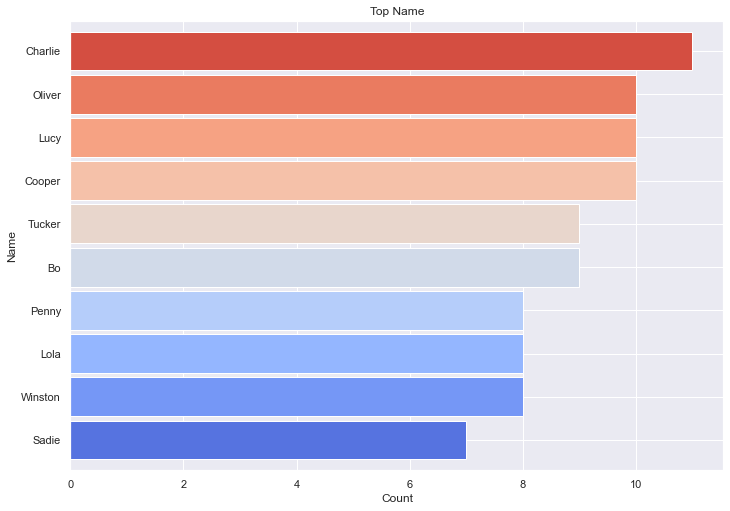

In [75]:
twitter_archives.name.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('coolwarm',10))
plt.title('Top Name')
set_label('Count', 'Name')

- Above chart shows that Charlie is the most popular dog folowed by Bo, Lola, Cooper and Oliver. Buddy is the least popular dog

**Pattern followed by Dog Ratings Per Day**

Text(0.5, 1.0, 'Median Rating of each dog tweet per day')

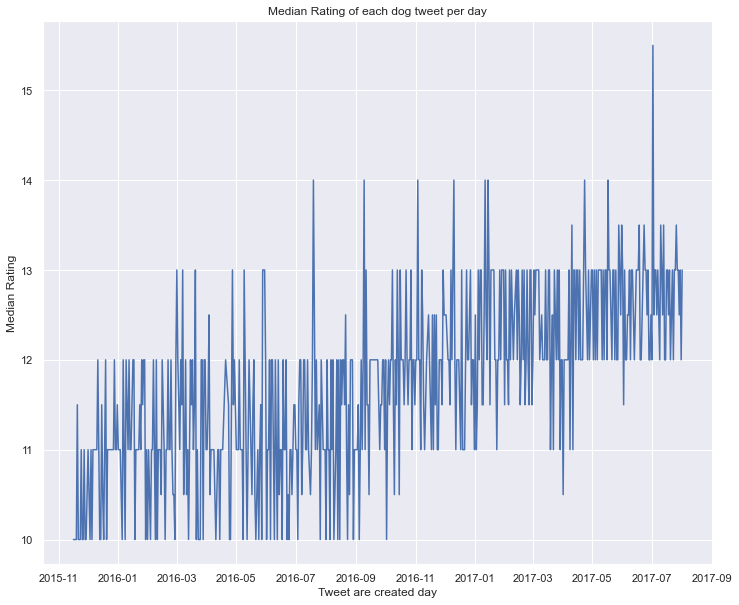

In [76]:
twitter_archives['created_at'] = pd.to_datetime(twitter_archives.created_at)

plt.subplots(figsize=(12,10))
twitter_archives.groupby(twitter_archives['created_at'].dt.date).median()['rating_numerator'].plot()
set_label('Tweet are created day', 'Median Rating')
plt.title('Median Rating of each dog tweet per day')


- The above graph has a gradual increase in the dog rating with few spikes followed by a constant step increases

**Pattern followed by Dog Ratings Per Month**

/Users/robertgadzai/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Text(0.5, 1.0, 'Median rating of dog tweet per month')

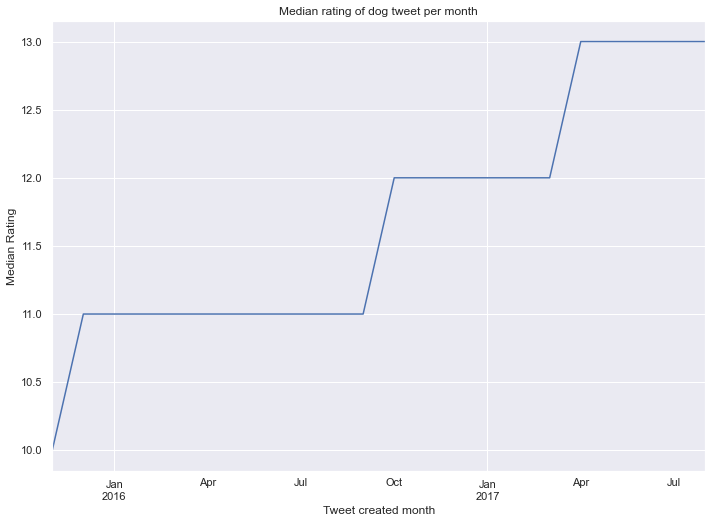

In [77]:
twitter_archives.groupby(twitter_archives['created_at'].dt.to_period("M")).median()['rating_numerator'].plot()
set_label('Tweet created month', 'Median Rating')
plt.title('Median rating of dog tweet per month')


- The above graph shows a flat constant flow with step sharp random rise 

**Correlation between Dogs Favorite Count and Retweet count**

Text(0.5, 1.0, 'Favorite vs Retweet Count')

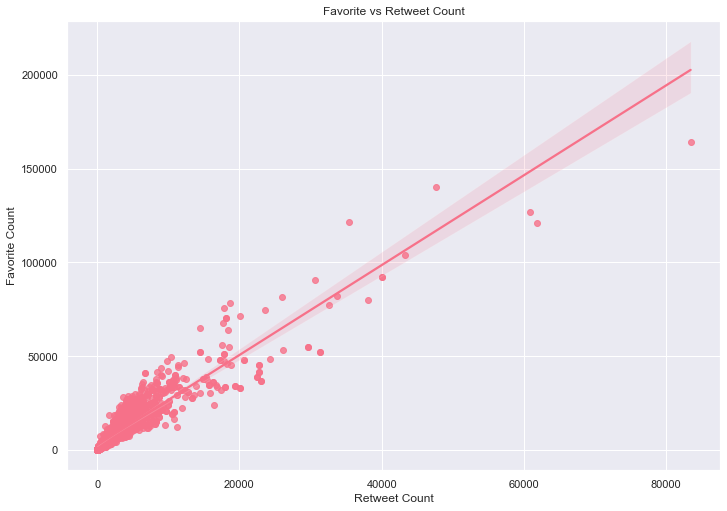

In [78]:
sns.set_palette("husl")
sns.regplot(
    x='retweet_count', 
    y='favorite_count', data=twitter_archives)
set_label("Retweet Count", "Favorite Count")

plt.title('Favorite vs Retweet Count')

- Above graph shows a correlation between the retweet count and favourite count. This could entail that people retweet a dog they favour the most